# Ridge, LASSO, Root-LASSO Regression

In [3]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline

## Simulating the AR model
simulate 2nd order AR model: <latex>$y_{k} = a_1y_{k-1}+a_2y_{k-2}+w_{k}$

In [22]:
def systemSimulation(N,a1,a2,noisePwr,signalPwr):
    '''
    @N: int, length of the sequence
    @a1: float, param 1
    @a2: float, param 2
    @noisePwr: float, power of noise
    w: AWGN noise
    '''
    y = np.zeros(N)
    y[0:2] = np.array([5,10])
    for i in range(N-2):
        y[i+2] = a1*y[i+1]+a2*y[i]+np.random.randn()*np.sqrt(noisePwr)
    return y

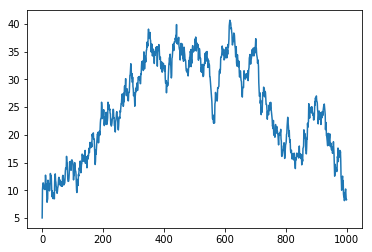

In [23]:
y = systemSimulation(1000,0.9,0.1,1,100)
plt.plot(y)

In [31]:
## Classical Least Square

In [40]:
def RidgeRegression(y,lambdaParam):
    '''
    @lambdaParam: float, parameter for Ridge penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    estimatedParam = np.linalg.inv(phi@phi.T+lambdaParam*np.eye(2))@phi@y[2:]
    return estimatedParam

In [41]:
for lambdaParam in range(10):
    RidgeEstimation = RidgeRegression(y,lambdaParam*100+1)
    print(RidgeEstimation)

[ 0.90299118  0.09628877]
[ 0.84020676  0.15900195]
[ 0.7943175   0.20481945]
[ 0.7593094   0.23975547]
[ 0.73172002  0.26727253]
[ 0.70941509  0.28950501]
[ 0.69100735  0.30784017]
[ 0.67555605  0.32321881]
[ 0.66240068  0.33630147]
[ 0.65106385  0.34756553]


In [42]:
def LassoRegression(y,lambdaParam):
    '''
    @lambdaParam: float, parameter for LASSO penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    LassoEstimation = Variable(2)
    objective = Minimize(sum_squares(y[2:] - phi.T@LassoEstimation)+lambdaParam*pnorm(LassoEstimation,1))
    prob = Problem(objective)
    result = prob.solve()
    return LassoEstimation.value

In [43]:
for lambdaParam in range(10):
    LassoEstimation = LassoRegression(y,lambdaParam*100+1)
    print(LassoEstimation)

[[ 0.90373553]
 [ 0.0955444 ]]
[[ 0.90370303]
 [ 0.09550363]]
[[ 0.90389759]
 [ 0.09523576]]
[[ 0.90363136]
 [ 0.09542879]]
[[ 0.90359263]
 [ 0.09539426]]
[[ 0.90356535]
 [ 0.09534828]]
[[ 0.90352447]
 [ 0.0953159 ]]
[[ 0.90348877]
 [ 0.09527835]]
[[ 0.90345407]
 [ 0.09523979]]
[[ 0.90342484]
 [ 0.09519575]]


In [44]:
def LeastSquareRegression(y):
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    estimatedParam = np.linalg.inv(phi@phi.T)@phi@y[2:]
    return estimatedParam

In [45]:
LSEstimation = LeastSquareRegression(y)
print(LSEstimation)

[ 0.903736    0.09554466]


In [46]:
def RootLassoRegression(y,muParam):
    '''
    @muParam: float, parameter for Square Root LASSO penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    n = np.sqrt(len(y))
    RootLassoEstimation = Variable(2)
    objective = Minimize(n*sum_squares(y[2:] - phi.T@RootLassoEstimation)+muParam*pnorm(RootLassoEstimation,1))
    prob = Problem(objective)
    result = prob.solve(solver='CVXOPT')
    return RootLassoEstimation.value

In [47]:
for muParam in range(10):
    RootLassoEstimation = RootLassoRegression(y,muParam*100+1)
    print(RootLassoEstimation)

[[ 0.90373479]
 [ 0.09554585]]
[[ 0.90365925]
 [ 0.0956191 ]]
[[ 0.90392248]
 [ 0.09535336]]
[[ 0.90377267]
 [ 0.0955009 ]]
[[ 0.90381081]
 [ 0.09546049]]
[[ 0.90377783]
 [ 0.09549119]]
[[ 0.90369635]
 [ 0.09557034]]
[[ 0.90382596]
 [ 0.09543834]]
[[ 0.90414436]
 [ 0.09511726]]
[[ 0.90375193]
 [ 0.09550783]]
